<a href="https://colab.research.google.com/github/juanpablosalas/SalasJuanPablo_RECV_Entrega5/blob/main/SalasJuanPablo_RECV_Entrega5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [161]:
#-- Descomprimimos el dataset
# !rm -r mnist
#!unzip "/content/drive/MyDrive/Colab Notebooks/mnist.zip"

#Carga de datos

In [162]:
from glob import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from sklearn.metrics import f1_score

In [163]:
# Se importan los datos de MNIST
train_files = glob('./mnist/train/*/*.png')
valid_files = glob('./mnist/valid/*/*.png')
test_files = glob('./mnist/test/*/*.png')

train_files[0]

'./mnist/train/0/3565.png'

In [164]:
#Se aleatorizan los datos 
np.random.shuffle(train_files)
np.random.shuffle(valid_files)
np.random.shuffle(test_files)

len(train_files), len(valid_files), len(test_files)

(6000, 2000, 992)

In [165]:
#Datos de entrenamiento
N_train = len(train_files)
X_train = []
Y_train = []

for i, train_file in enumerate(train_files):
  Y_train.append( int(train_file.split('/')[3]) )
  X_train.append(np.array(Image.open(train_file)))

In [166]:
#Datos de validación
N_valid = len(valid_files)
X_valid = []
Y_valid = []

for i, valid_file in enumerate(valid_files):
  Y_valid.append( int(valid_file.split('/')[3]) )
  X_valid.append( np.array(Image.open(valid_file)) )

In [167]:
#Datos de testeo
N_test = len(test_files)
X_test = []
Y_test = []

for i, test_file in enumerate(test_files):
  Y_test.append( int(test_file.split('/')[3]) )
  X_test.append( np.array(Image.open(test_file)) )

In [168]:
#Transformación de arreglos a tensores
X_train = Variable(torch.from_numpy(np.array(X_train))).float()
Y_train = Variable(torch.from_numpy(np.array(Y_train))).long()

X_valid = Variable(torch.from_numpy(np.array(X_valid))).float()
Y_valid = Variable(torch.from_numpy(np.array(Y_valid))).long()

X_test = Variable(torch.from_numpy(np.array(X_test))).float()
Y_test = Variable(torch.from_numpy(np.array(Y_test))).long()

X_train.data.size()

torch.Size([6000, 28, 28])

In [169]:
#ANN de tres capas ocultas y 50 neuronas 
input_dim = 28*28
out_dim = 10
hidden = 50

model = torch.nn.Sequential(
  torch.nn.Linear(input_dim, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, hidden),
  torch.nn.ReLU(),       
  torch.nn.Linear(hidden, out_dim)
)

optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

#Variando el número de datos de entrenamiento

In [170]:
def curvas_train_only(train_percentage):
  X_train_small = X_train[0:int(N_train*train_percentage/100)]
  Y_train_small = Y_train[0:int(N_train*train_percentage/100)]
  #-- Número de épocas
  n_epoch = 100
  
  #-- Listas de evaluación entrenamiento
  loss_train = []
  f1_train = []
  acc_train = []
  
  #-- Listas de evaluación validació
  loss_valid = []
  f1_valid = []
  acc_valid = []
  
  #-- Entrenamineto de la ANN
  for epoch in range(n_epoch):
    model.train()
    
    Xtr = X_train_small.view(X_train_small.size(0), -1)
    Y_pred = model(Xtr)
    
    loss = criterion(Y_pred,Y_train_small)
    loss_train.append(loss.item())
    
    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train_small,Y_pred, average='macro') )
    
    acc = sum(Y_train_small == Y_pred)/len(Y_pred)
    acc_train.append(acc)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )
    
    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())
    
    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )
    
    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

    #Curvas de loss, f1_score y accuracy
  fig = plt.figure(figsize=(15,5))
  plt.subplot(1,3,1)
  plt.plot(range(n_epoch), loss_train, label='train')
  plt.plot(range(n_epoch), loss_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.grid()
  plt.subplot(1,3,2)
  plt.plot(range(n_epoch), f1_train, label='train')
  plt.plot(range(n_epoch), f1_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('f1_score')
  plt.legend()
  plt.grid()
  plt.subplot(1,3,3)
  plt.plot(range(n_epoch), acc_train, label='train')
  plt.plot(range(n_epoch), acc_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid()
  plt.savefig('./curves_ok_'+str(train_percentage)+'.png', bbox_inches='tight')
  plt.show()

  model.eval()
  
  Xts = X_test.view(X_test.size(0), -1)
  Y_pred = model(Xts)  
  loss = criterion(Y_pred,Y_test)
  
  Y_pred = torch.argmax(Y_pred, 1)
  f1 = f1_score(Y_test, Y_pred, average='macro')
  acc = sum(Y_test == Y_pred)/len(Y_pred)
  print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

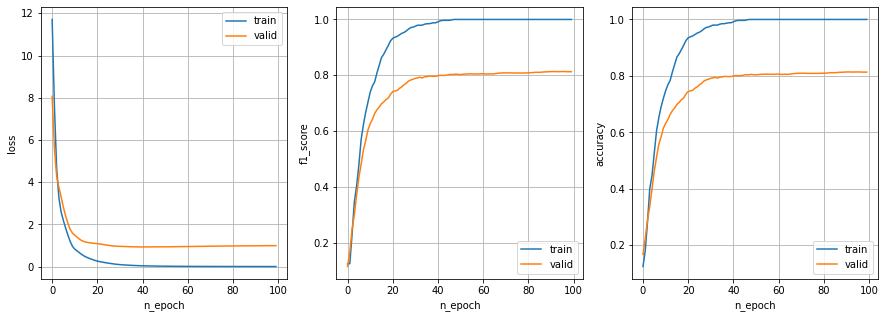

loss: 0.8994147777557373, f1: 0.8258178294166646, acc: 0.8266128897666931


In [171]:
curvas_train_only(10)

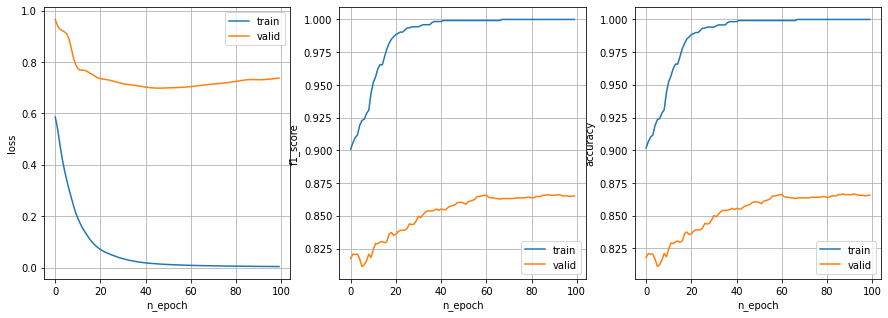

loss: 0.7510964274406433, f1: 0.8589683158208261, acc: 0.8598790168762207


In [172]:
curvas_train_only(20)

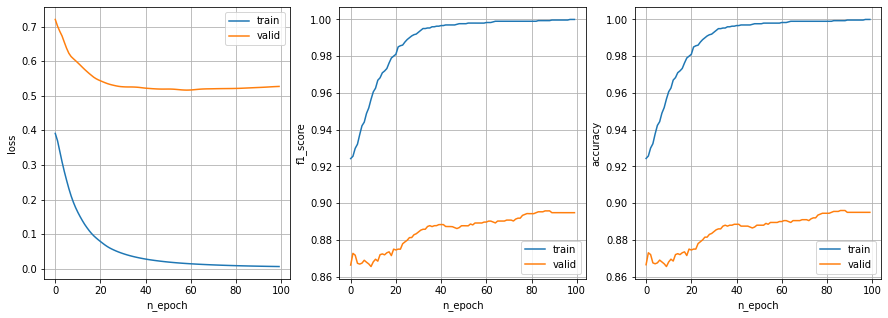

loss: 0.5454968810081482, f1: 0.875759153151199, acc: 0.8760080933570862


In [173]:
curvas_train_only(50)

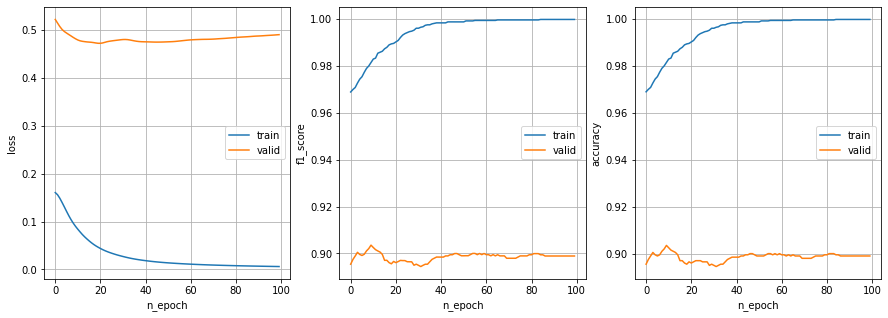

loss: 0.4709876477718353, f1: 0.9022205505825213, acc: 0.9022177457809448


In [174]:
curvas_train_only(80)

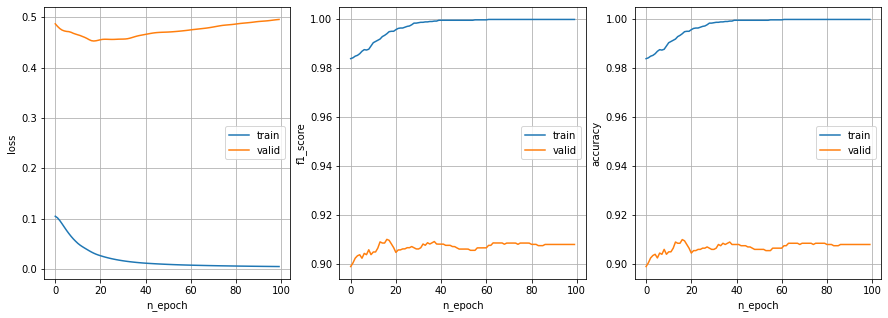

loss: 0.4611530303955078, f1: 0.9138877663083796, acc: 0.9143145084381104


In [175]:
curvas_train_only(100)

**i) Indique cuál es la importancia del tamaño del conjunto de entrenamiento** <br>
**ii) Compare las curvas de entrenamiento y validación usando los 3 scores** <br>
**iii) haga un breve análisis de los resultado obtenidos**

El tamaño del conjunto de entrenamiento es un factor significativo en las redes neuronales puesto que con más datos para entrenar, se podrán tener resultados más precisos y reducir las pérdidas. Lo anterior se puede observar en las anteriores gráficas puesto que al aumentar el porcentaje de datos de entrenamiento utilizados, se disminuye la pérdida (loss) mientras que aumentan las medidas de preicisón (f_1 score y accuracy). En todos los casos se mantiene que las pérdidas del conjunto de validación es mayor al conjunto de datos de entrenamiento mientras que la precisión de los datos de entrenamiento es siempre mayor que los de validación. Esto tiene sentido puesto que el modelo se hizo basado en los datos de entrenamiento. Por esta misma razón es que las curvas de los datos de entrenamiento se ven más estables en todos los casos.

In [176]:
def curvas_test_only(test_percentage):
  X_test_small = X_test[0:int(N_test*test_percentage/100)]
  Y_test_small = Y_test[0:int(N_test*test_percentage/100)]
  #-- Número de épocas
  n_epoch = 100
  
  #-- Listas de evaluación entrenamiento
  loss_train = []
  f1_train = []
  acc_train = []
  
  #-- Listas de evaluación validació
  loss_valid = []
  f1_valid = []
  acc_valid = []
  
  #-- Entrenamineto de la ANN
  for epoch in range(n_epoch):
    model.train()
    
    Xtr = X_train.view(X_train.size(0), -1)
    Y_pred = model(Xtr)
    
    loss = criterion(Y_pred,Y_train)
    loss_train.append(loss.item())
    
    Y_pred = torch.argmax(Y_pred, 1)
    f1_train.append( f1_score(Y_train,Y_pred, average='macro') )
    
    acc = sum(Y_train == Y_pred)/len(Y_pred)
    acc_train.append(acc)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    #print( 'Epoch [{}/{}], loss: {}. f1:{} acc: {} '.format(epoch+1,n_epoch,loss_train[-1], f1_train[-1], acc_train[-1]) )
    
    model.eval()
    Xvl = X_valid.view(X_valid.size(0), -1)
    Y_pred = model(Xvl)  
    loss = criterion(Y_pred,Y_valid)
    loss_valid.append(loss.item())
    
    Y_pred = torch.argmax(Y_pred, 1)
    f1_valid.append( f1_score(Y_valid, Y_pred, average='macro') )
    
    acc = sum(Y_valid == Y_pred)/len(Y_pred)
    acc_valid.append(acc)

    #Curvas de loss, f1_score y accuracy
  fig = plt.figure(figsize=(15,5))
  plt.subplot(1,3,1)
  plt.plot(range(n_epoch), loss_train, label='train')
  plt.plot(range(n_epoch), loss_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('loss')
  plt.legend()
  plt.grid()
  plt.subplot(1,3,2)
  plt.plot(range(n_epoch), f1_train, label='train')
  plt.plot(range(n_epoch), f1_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('f1_score')
  plt.legend()
  plt.grid()
  plt.subplot(1,3,3)
  plt.plot(range(n_epoch), acc_train, label='train')
  plt.plot(range(n_epoch), acc_valid, label='valid')
  plt.xlabel('n_epoch')
  plt.ylabel('accuracy')
  plt.legend()
  plt.grid()
  plt.savefig('./curves_ok_'+str(test_percentage)+'.png', bbox_inches='tight')
  plt.show()

  model.eval()
  Xts = X_test_small.view(X_test_small.size(0), -1)
  Y_pred = model(Xts)  

  loss = criterion(Y_pred,Y_test_small)
  
  Y_pred = torch.argmax(Y_pred, 1)
  f1 = f1_score(Y_test_small, Y_pred, average='macro')
  acc = sum(Y_test_small == Y_pred)/len(Y_pred)
  print('loss: {}, f1: {}, acc: {}'.format(loss.item(), f1, acc))

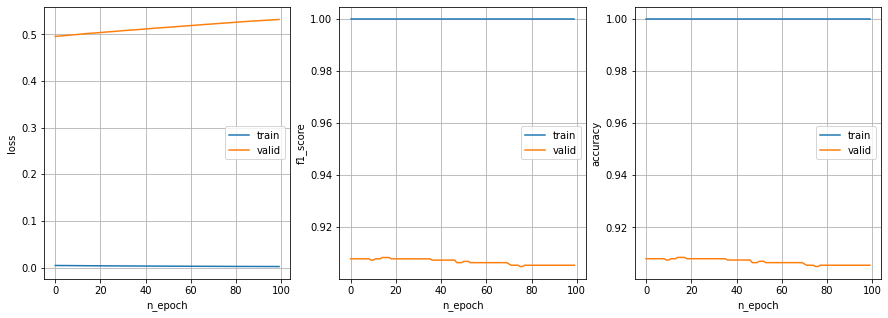

loss: 0.3595069348812103, f1: 0.9059473728885493, acc: 0.9090909361839294


In [177]:
curvas_test_only(10)

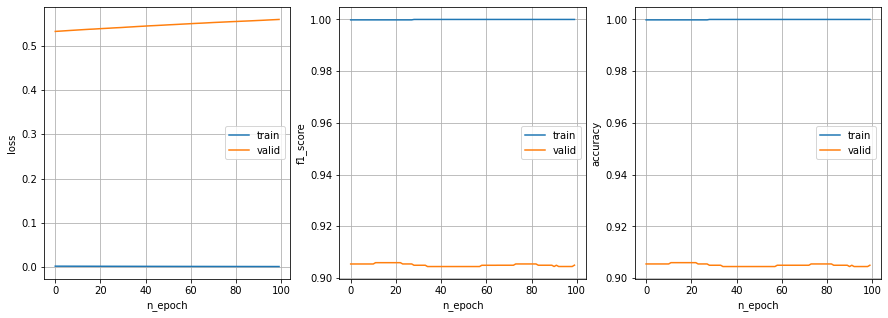

loss: 0.3786955177783966, f1: 0.9260171451513626, acc: 0.9242424368858337


In [178]:
curvas_test_only(20)

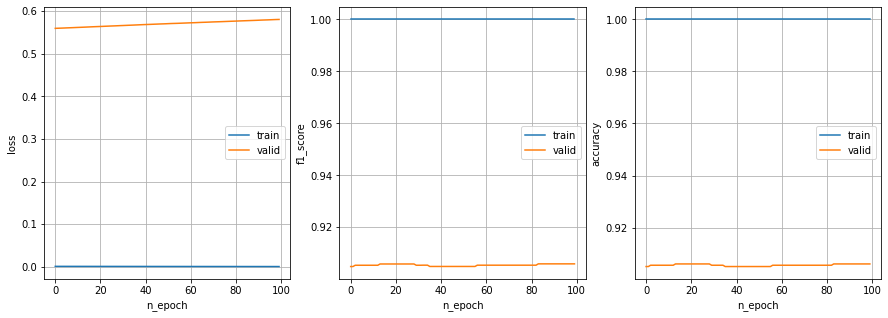

loss: 0.53911954164505, f1: 0.8997496195402034, acc: 0.899193525314331


In [179]:
curvas_test_only(50)

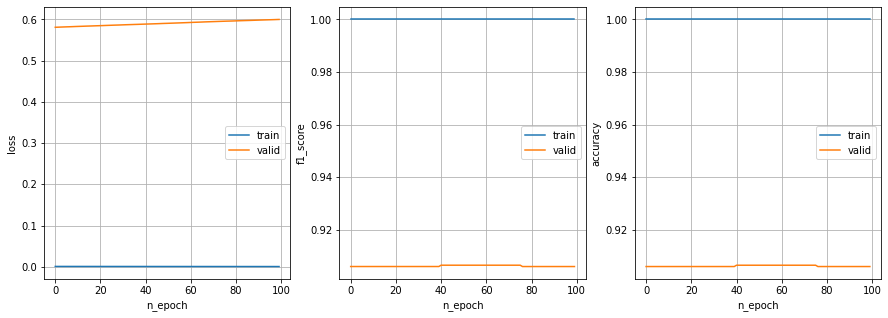

loss: 0.5424231290817261, f1: 0.9104316648974665, acc: 0.9104666113853455


In [180]:
curvas_test_only(80)

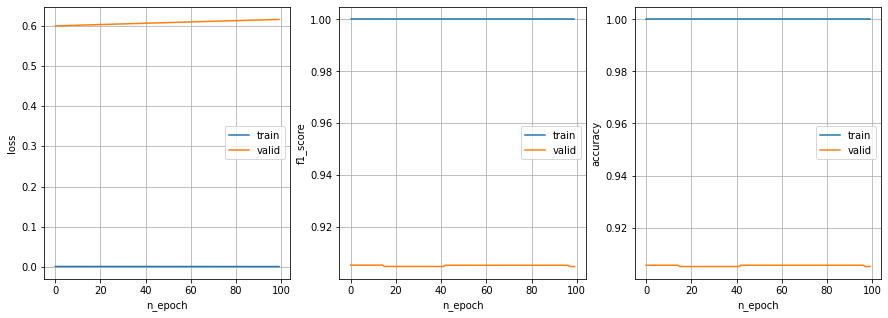

loss: 0.5557163953781128, f1: 0.9139564872515662, acc: 0.9143145084381104


In [181]:
curvas_test_only(100)

 **i) Indique cuál es la importancia del tamaño del conjunto de testeo** <br>
 **ii) Compare los score obtenidos en cada caso** <br>
 **iii) Haga un breve análisis de los resultado obtenidos.**

El conjunto de testeo es importante pues son los datos a los que se quiere aplicar el modelo. Su tamaño es importante porque pone ciertas restricciones sobre los otros conjuntos de datos. Es decir, es más complicado hacer un modelo cuyo número de datos de testeo sea cercano (o mayor) que el número de datos de entrenamiento. También puede representar un factor de qué tan bueno es nuestro modelo, si al utilizar un conjunto mayor de datos de testeo NO se altera significativamente la pérdida y la precisión. En este caso, al usar diferentes porcentajes de datos de testeo se puede ver que la precisión (f1 score y accuracy) no varía significativamente. Por otro lado, la pérdida pareciera estabilizarse después de usar el 50% de los datos en alrededor de 0.55 (con un número menor de datos se obtiene un valor cercano a 0.35). El hecho de que la precisión no varíe significativemente da cuenta a que el modelo es sólido pues se utiliza una gran proporción de datos de entrenamiento.